In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from scipy.constants import e, k, h
from scipy.interpolate import interp1d
import itertools
from numba import jit
from numba.typed import List
from scipy.optimize import minimize, basinhopping
rok_energy = 1e-3*e
Delta = 0.166*1e-3*e

In [2]:
%load_ext jupyternotify


<IPython.core.display.Javascript object>

In [3]:
@jit(nopython=True)
def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

@jit(nopython=True)
def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

@jit(nopython=True)
def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator
    

In [4]:
@jit(nopython=True)
def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

@jit(nopython=True)
def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dng - dne) + dne)

@jit(nopython=True)
def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

@jit(nopython=True)
def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

@jit(nopython=True)
def I_resistance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

### Task 1
Check if my plot shown in slide 6 of today’s slides is correct? (Uncoupled case, reproduced bellow)
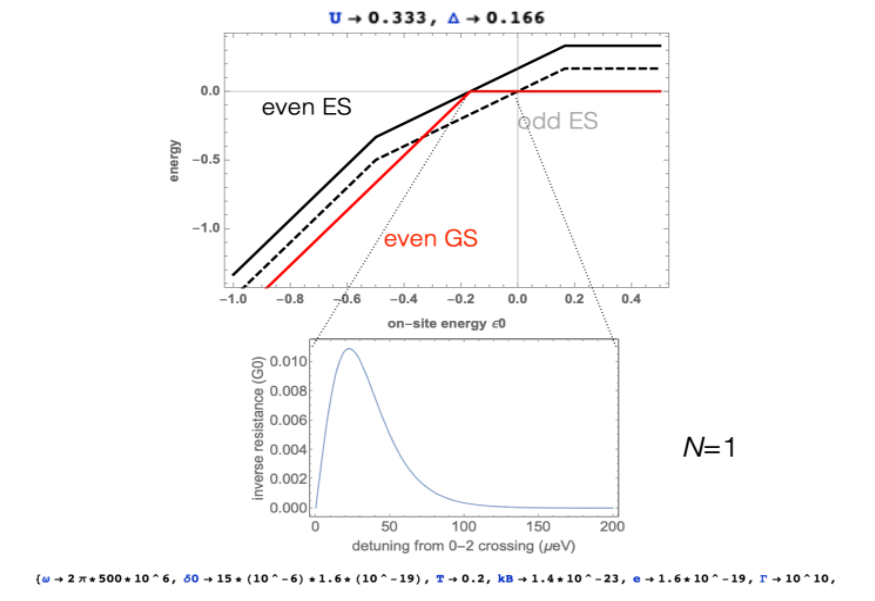

Text(0, 0.5, '$\\frac{R_Q}{R_sis}$')

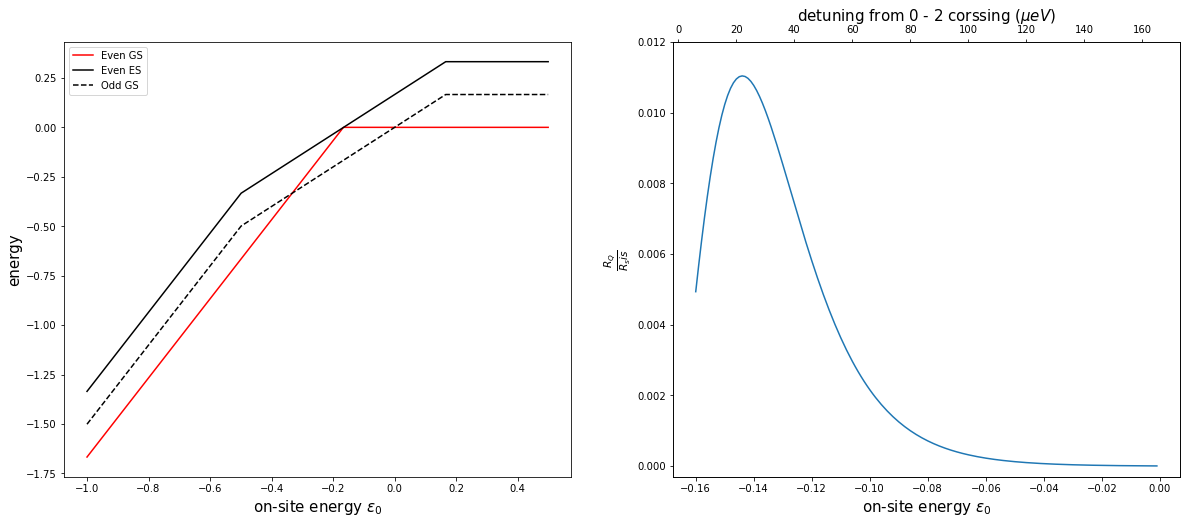

In [5]:
def uncoupled_energy(v0, U = 0.333,Delta = 0.166,st=0): #st=0 implies even state
    even_states = np.array([[0,0], [0,2], [1,1], [2,0], [2,2]])
    odd_states = np.array([[0,1], [1,0], [1,2], [2,1]])
#     v0 = np.arange(-1,0.5,.01)
    if st:
        states = odd_states
    else:
        states = even_states
    try:
        s_mgset = np.zeros([len(states),len(v0)])
    except:
        s_mgset = np.zeros([len(states),1])
    for idx, ndnq in enumerate(states):
        nd,nq = ndnq
        s_mgset[idx,:] = (v0)*nd + 0.5*U*nd*(nd-1) + Delta*nq
    return s_mgset

def uncoupled_energy_sort(v0, minidx, U = 0.333,Delta = 0.166,st=0):
    return np.sort(uncoupled_energy(v0,U,Delta,st),0)[minidx]

v0 = np.arange(-1,0.5,0.001)
v0p = np.arange(-0.166,0,0.001)
fig, axes = plt.subplots(1,2,figsize=(20,8))

even_gs = uncoupled_energy_sort(v0,0)
odd_gs = uncoupled_energy_sort(v0,0,st=1)
even_es = uncoupled_energy_sort(v0,1)
smg = (even_es - even_gs)*e*1e-3
dsmg = np.gradient(smg,0.001)/(1e-3*e)

axes[0].plot(v0,even_gs,'red',label='Even GS')
axes[0].plot(v0,even_es,'k',label='Even ES')
axes[0].plot(v0,odd_gs,'k--',label='Odd GS')
axes[0].legend()

axes[0].set_xlabel(r'on-site energy $\epsilon_0$',fontsize=15)
axes[0].set_ylabel('energy',fontsize=15)


ax1 = axes[1]
ax2 = ax1.twiny()

def tick_function(X):
    V = X
    return ["%.3f" % z for z in V]


tempdum = ax2.plot(1e3*(v0[840:1000]+0.166), v0[840:1000]+0.166) # Create a dummy plot
temdum2 = tempdum.pop(0)
temdum2.remove()
ax1.set_ylim(-0.0003,0.012)
ax2.tick_params(axis='y')


ax2.set_xlabel(r"detuning from 0 - 2 corssing ($\mu eV$)",fontsize=15)


axes[1].plot(v0[840:1000],-(h/(2*e**2))*I_resistance(1e10,smg, dsmg, 0.2, 1, 1, 0, 2*np.pi*500e6)[840:1000])
axes[1].set_xlabel(r'on-site energy $\epsilon_0$',fontsize=15)
axes[1].set_ylabel(r'$\frac{R_Q}{R_sis}$',fontsize=15)


### Task 2
Generate plots with Rok’s fitted parameters. First, pick the lowest Gamma_tun and the highest Gamma_tun, and take Gamma = 10^10 Hz. For a fixed parameter set, produce a 6-panel plot, with the 6 panels arranged vertically, all showing functions of the on-site energy

(a) Shiba minigap 

(b) even ground-state charge, odd ground-state charge, their difference

(c) equilibrium ground-state population 

(d) quantum capacitance

(e) tunneling capacitance

(f) inverse Sis resistance

In [6]:
def RC_data(gammaa,g0,T,N,U=0.333,save=False):
    v0 = np.arange(-0.8,0.4,.01)
    nu = 0.5 - (v0/U)
    w = 2*np.pi*268*1e6

    op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg
    # chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi1.dat") # dng
    n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat") # ng
    # chi2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi2.dat") # dne
    n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat") # ne

    s_mg_f = interp1d(op1[:,0],op1[:,1])
    ds_mg_f = interp1d(op1[:,0],np.gradient(op1[:,1],-0.01*U))
    n_g_f = interp1d(n1[:,0],n1[:,1])
    chi_g_f = interp1d(n1[:,0],np.gradient(n1[:,1],-0.01*U))
    n_e_f = interp1d(n2[:,0],n2[:,1])
    chi_e_f = interp1d(n2[:,0],np.gradient(n2[:,1],-0.01*U))

    s_mg = s_mg_f(nu)*Delta
    ds_mg = ds_mg_f(nu)*Delta/rok_energy
    n_g = n_g_f(nu)
    dn_g = chi_g_f(nu)/rok_energy
    n_e = n_e_f(nu)
    dn_e = chi_e_f(nu)/rok_energy
    
    
    P0_eq = p0(s_mg, T, N)
    Q_Caps = -q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    # Cap = total_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, dn_e, dn_g, w)
    IRes = -1000*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*h/(2*e**2)

    
    fig, axes = plt.subplots(6,1,figsize=(10,24))
    axes = axes.flatten()
    idx = 0
    
    axes[0].plot(v0,s_mg/(e*1e-3),label=f'$\delta$')
    axes[0].set_ylabel('$\delta \ (meV) $',fontsize=15)
#     axes[0].set_ylim(0,0.38)

    axes[1].plot(v0,n_g,label=f'$n_1$')
    axes[1].plot(v0,n_e,label=f'$n_2$')
    axes[1].plot(v0,n_g-n_e,label=f'$n_1 - n_2$')
    axes[1].set_ylabel('n',fontsize=15)
    axes[1].legend()
#     axes[1].set_ylim(-1.2,2.2)

    axes[2].plot(v0,P0_eq,label=f'$P_0$')
    axes[2].set_ylabel('$P_0$',fontsize=15)
#     axes[2].set_ylim(-0.02,1.1)

    axes[3].plot(v0,Q_Caps,label=f'$C_Q (fF)$')
    axes[3].set_ylabel('$C_q (fF) $',fontsize=15)
#     axes[3].set_ylim(-0.1,5.6)
    
    axes[4].plot(v0,T_Caps,label=f'$C_t (fF) $')
    axes[4].set_ylabel('$C_t (fF) $',fontsize=15)
#     axes[4].set_ylim(-0.1,2.4)
    
    axes[5].plot(v0,IRes,label='$\\frac{R_Q}{R}$')
    axes[5].set_ylabel('$\\dfrac{R_Q}{R} 10^3$',fontsize=15)
    axes[5].set_xlabel('$\epsilon_0$',fontsize=15)
#     axes[5].set_ylim(-0.1,4.7)
    
    parameter_string = f"\
            $U          = 0.333 $\
            $\\Gamma_t      = {gammaa} $\
            $\\omega      = 2\pi 268 MHz $\
            $\\Gamma^0      = 10^{({10})} Hz $\
            $T             = 200 mK $\
            $log_{{10}} N   = {np.log10(N)}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    
    if save:
        plt.savefig(f"plots_min{gammaa}.{'pdf'}", format='pdf')
    # for axiss in axes:
    #     axiss.legend()

In [7]:
# RC_data('0.160',1e10,0.2,10000,U=0.333,save=False)

### Task 3
Make the same 6-panel plot for the uncoupled model as well

In [6]:
def uncoupled_energy(v0, U = 0.333,Delta = 0.166,st=0):
    even_states = np.array([[0,0], [0,2], [1,1], [2,0], [2,2]])
    odd_states = np.array([[0,1], [1,0], [1,2], [2,1]])
#     v0 = np.arange(-1,0.5,.01)
    if st:
        states = odd_states
    else:
        states = even_states
    try:
        s_mgset = np.zeros([len(states),len(v0)])
    except:
        s_mgset = np.zeros([len(states),1])
    for idx, ndnq in enumerate(states):
        nd,nq = ndnq
        s_mgset[idx,:] = (v0)*nd + 0.5*U*nd*(nd-1) + Delta*nq
    return s_mgset

def uncoupled_energy_sort(v0, minidx, U = 0.333,Delta = 0.166,st=0):
    return np.sort(uncoupled_energy(v0,U,Delta,st),0)[minidx]

In [7]:
def n1func(v0,st=0):
    even_states = np.array([[0,0], [0,2], [1,1], [2,0], [2,2]])
    odd_states = np.array([[0,1], [1,0], [1,2], [2,1]])
    size = 5
    if st: size=4
    n1list = []
    for vess in v0:
        minenergy = uncoupled_energy_sort(vess,0,st=st)
        allenergy = uncoupled_energy(vess,st=st)
        for joms in range(size):
            if allenergy[joms]==minenergy:
                if st:
                    n1list.append(odd_states[joms,0])
                else:
                    n1list.append(even_states[joms,0])
    return np.array(n1list)

In [8]:
def n2func(v0,st=0):
    even_states = np.array([[0,0], [0,2], [1,1], [2,0], [2,2]])
    odd_states = np.array([[0,1], [1,0], [1,2], [2,1]])
    size = 5
    if st: size=4
    n1list = []
    for vess in v0:
        minenergy = uncoupled_energy_sort(vess,1,st=st)
        allenergy = uncoupled_energy(vess,st=st)
        for joms in range(size):
            if allenergy[joms]==minenergy:
                if st:
                    n1list.append(odd_states[joms,0])
                else:
                    n1list.append(even_states[joms,0])
    return np.array(n1list)

In [9]:
def uncoupsiba(v0):
    return uncoupled_energy_sort(v0, 1) - uncoupled_energy_sort(v0, 0)

In [10]:
def RC_uncoupled_data(g0,T,N,U=0.333,save=False):
    v0 = np.arange(-0.8,0.5,.01)
#     nu = 0.5 - (v0/U)
    w = 2*np.pi*268*1e6

    s_mg = uncoupsiba(v0)*1e-3*e
    ds_mg = n2func(v0,st=0) - n1func(v0,st=0) 
    n_g = n1func(v0,st=0)
    dn_g = np.gradient(n_g,0.01)
    n_e = n1func(v0,st=1)
    dn_e = np.gradient(n_e,0.01)
    P0_eq = p0(s_mg, T, N)
    
    
    Q_Caps = -q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    # Cap = total_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, dn_e, dn_g, w)
    IRes = -1e3*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*h/(e**2)

    
    fig, axes = plt.subplots(6,1,figsize=(10,24),sharex=True)
    axes = axes.flatten()
    axes[0].plot(v0,s_mg/(e*1e-3),label=f'$\delta$')
    axes[0].set_ylabel('$\delta \ (meV) $',fontsize=15)
    axes[0].set_ylim(0,0.38)


    axes[1].plot(v0,n_g,label=f'$n_1$')
    axes[1].plot(v0,n_e,label=f'$n_2$')
    axes[1].plot(v0,n_g-n_e,label=f'$n_1 - n_2$')
    axes[1].set_ylabel('n',fontsize=15)
    axes[1].legend()
    axes[1].set_ylim(-1.2,2.2)

    axes[2].plot(v0,P0_eq,label=f'$P_0$')
    axes[2].set_ylabel('$P_0$',fontsize=15)
    axes[2].set_ylim(-0.02,1.1)

    axes[3].plot(v0,Q_Caps,label=f'$C_Q (fF)$')
    axes[3].set_ylabel('$C_q (fF) $',fontsize=15)
    axes[3].set_ylim(-0.1,5.6)
    
    axes[4].plot(v0,T_Caps,label=f'$C_t (fF) $')
    axes[4].set_ylabel('$C_t (fF) $',fontsize=15)
    axes[4].set_ylim(-0.1,2.4)
    
    axes[5].plot(v0,IRes,label='$\\frac{R_Q}{R}$')
    axes[5].set_ylabel('$\\dfrac{R_Q}{R} 10^3$',fontsize=15)
    axes[5].set_xlabel('$\epsilon_0$',fontsize=15)
    axes[5].set_ylim(-0.1,10.6)

    parameter_string = f"\
            $U          = 0.333 $\
            $\\omega      = 2\pi 268 MHz $\
            $\\Gamma^0      = 10^{({10})} Hz $\
            $T             = 200 mK $\
            $log_{{10}} \ N    = {np.log10(N)}$"

    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    fig.text(
        0.5, 0.895, "Uncoupled", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=22)
    plt.rc('axes', labelsize=20) 
    if save:
        plt.savefig(f"plots_min{gammaa}.{'pdf'}", format='pdf')
    # for axiss in axes:
    #     axiss.legend()

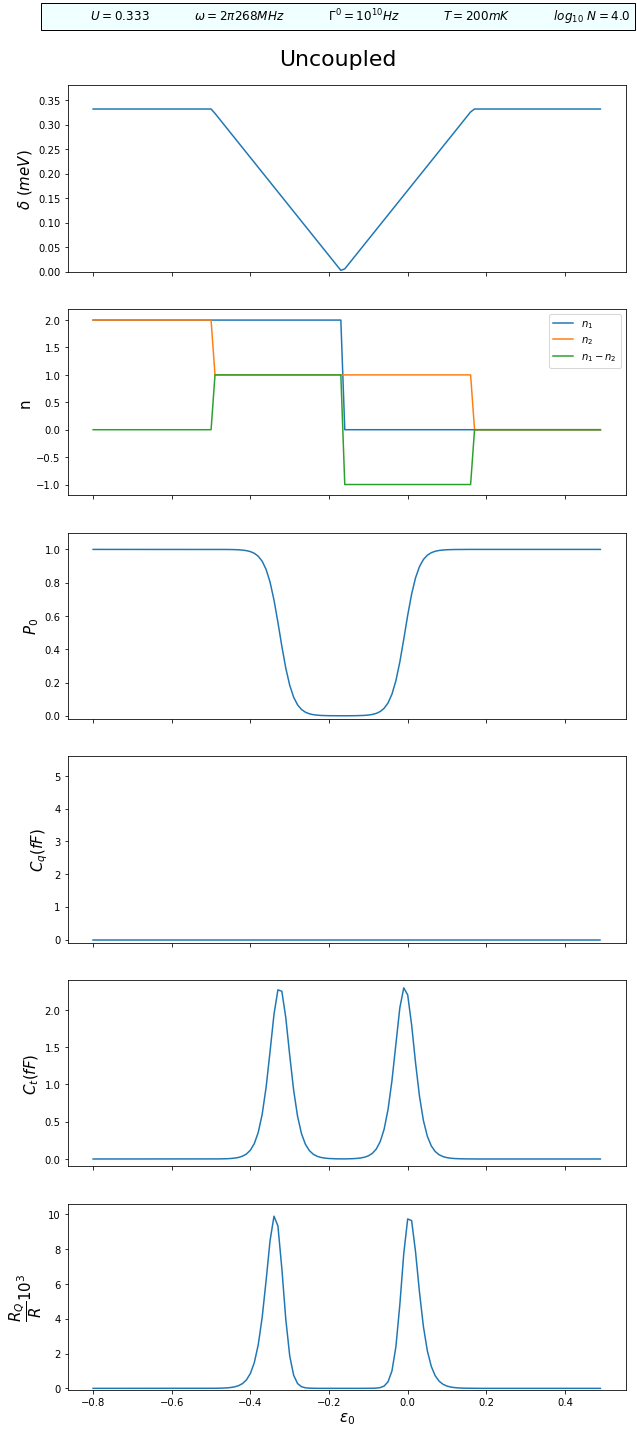

In [12]:
RC_uncoupled_data(1e10,0.2,10000,U=0.333*2,save=False)

### Task 4
Make vertical multi-panel plots showing Rok’s raw data for lowest Gamma_tun, highest Gamma_tun. Panels:

(a) Shiba minigap

(b) n1.dat

(c) n2.dat

(d) chi1.dat

(e) chi2.dat

Write a short note on how to convert those raw data to physical units.


In [14]:
def Rok_raw(gammaa,U=0.333,save=False):
#     v0 = np.arange(-0.5,2.5,.01)
#     nu = v0
#     nu = 0.5 - (v0/U)

    op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg

    n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat") # ng

    n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat") # ne
    
    v0 = op1[:,0]
    nu = v0

    s_mg_f = interp1d(op1[:,0],op1[:,1])
    ds_mg_f = interp1d(op1[:,0],np.gradient(op1[:,1],-0.01*U))

    n_g_f = interp1d(n1[:,0],n1[:,1])
    chi_g_f = interp1d(n1[:,0],np.gradient(n1[:,1],-0.01*U))
    n_e_f = interp1d(n2[:,0],n2[:,1])
    chi_e_f = interp1d(n2[:,0],np.gradient(n2[:,1],-0.01*U))

    s_mg = s_mg_f(nu)
    n_g = n_g_f(nu)
    dn_g = chi_g_f(nu)
    n_e = n_e_f(nu)
    dn_e = chi_e_f(nu)

    fig, axes = plt.subplots(5,1,figsize=(10,24),sharex=True)
    axes = axes.flatten()
    
    axes[0].plot(v0,s_mg,label='optical1.dat')
    axes[0].set_ylabel(r'$\delta$')
    axes[0].set_ylim(0.1,2.1)

    axes[1].plot(v0,n_g,label=r'$n_1.dat$')
    axes[1].set_ylabel(r'$n_1$',fontsize=14)
    axes[1].set_ylim(-0.1,2.1)

    axes[2].plot(v0,n_e,label=r'$n_2.dat$')
    axes[2].set_ylabel(r'$n_2$',fontsize=14)
    axes[2].set_ylim(-0.1,2.1)
    
    axes[3].plot(v0,dn_g,label=r'$\chi_1 = \frac{dn_1}{\epsilon_0} = -1*chi1.dat$')
    axes[3].set_ylabel(r'$\chi_1$',fontsize=14)
    axes[3].set_ylim(-46,2)

    axes[4].plot(v0,dn_e,label=r'$\chi_2 = \frac{dn_2}{\epsilon_0} = -1*chi2.dat$')
    axes[4].set_ylabel(r'$\chi_2$',fontsize=14)
    axes[4].set_ylim(-26,1)
    
    for axiss in axes:
        axiss.legend(fontsize=14)
        axiss.set_xlabel(r'$ \nu \ (meV) $',fontsize=14)


    parameter_string = f"$U          = 0.333 $      $\\Gamma_t      = {gammaa} $"

    fig.text(
        0.5, 0.9, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if save:
        plt.savefig(f"plots_min{gammaa}.{'pdf'}", format='pdf')
    # for axiss in axes:
    #     axiss.legend()

In [15]:
# Rok_raw('0.110',U=0.333)

### Notes on Conversion:
* Collumn 1 of all data files is $\nu = 0.5 - \dfrac{\epsilon_0}{U}$ in units of 1 rok energy $\approx 1 \ meV$
    * thus in finding $\chi = \dfrac{d n}{d \epsilon_0}$, we must take $d \epsilon_0 = - U d \nu$
* The shiba minigap data in `optical1.dat` is in units of $\Delta = 0.166 \ meV$
* When calculating the derivative of $n_1 \ n_2 \ \& \ \delta$, the conversion from rok energy must be done


# Fitting

In [16]:
# def P0plots(gammaa,g0,T,N,U=0.333,save=False):
#     plt.close()
#     op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg
#     s_mg_f = interp1d(op1[:,0],op1[:,1])

#     s_mg = op1[:,1]
#     v0 = op1[:,0]
#     P0_eq = p0(s_mg, T, N)
#     print(np.mean(np.abs(P0_eq)))
#     plt.plot(v0[:-1],P0_eq,label=r'(\delta(V0) - \delta(-V0)) / \delta(V0)')
#     plt.ylabel(r'$\dfrac{e^{\delta(V0)} - e^{\delta(-V0)}}{e^{\delta(V0)}}$',fontsize=15)
#     plt.xlabel(r'$\nu$')
#     plt.gcf().set_facecolor('white')
    
#     parameter_string = f"\
#             $U          = 0.333 $\
#             $\\Gamma_t      = {gammaa} $\
#             $T             = 200 mK $\
#             $log_{{10}} N   = {np.log10(N)}$"
    
#     if save:
#         plt.savefig(f"plots_min{gammaa}.{'pdf'}", format='pdf')
# @jit(nopython=True)
# def symmmm(data):
#     data = data[:-1]
#     return ((data - data[::-1])/data)
# @jit(nopython=True)
# def p0(smg, T, N):
#     numerator = np.exp(smg/(k*T))
#     denominator = np.exp(smg/(k*T)) + N
    
#     return symmmm(numerator/denominator)
# P0plots('0.02625',10**0.5,10/(1000*Delta),1e17)

In [17]:
def RC_data_phs(gammaa,g0,T,N,U=0.333,save=False):
    plt.close()
    v0 = np.arange(-0.5,0.5,.01)
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
    op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg
    # chi1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi1.dat") # dng
    n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat") # ng
    # chi2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\chi2.dat") # dne
    n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat") # ne

    s_mg_f = interp1d(op1[:,0],op1[:,1])
    ds_mg_f = interp1d(op1[:,0],np.gradient(op1[:,1],-0.01*U))
    n_g_f = interp1d(n1[:,0],n1[:,1])
    chi_g_f = interp1d(n1[:,0],np.gradient(n1[:,1],-0.01*U))
    n_e_f = interp1d(n2[:,0],n2[:,1])
    chi_e_f = interp1d(n2[:,0],np.gradient(n2[:,1],-0.01*U))

    s_mg = s_mg_f(nu)*Delta
    ds_mg = ds_mg_f(nu)*Delta/rok_energy
    n_g = n_g_f(nu)
    dn_g = chi_g_f(nu)/rok_energy
    n_e = n_e_f(nu)
    dn_e = chi_e_f(nu)/rok_energy
    
    
    P0_eq = p0(s_mg, T, N)
    Q_Caps = -q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    # Cap = total_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, dn_e, dn_g, w)
    IRes = -1000*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*h/(2*e**2)

    
    fig, axes = plt.subplots(6,1,figsize=(10,24))
    axes = axes.flatten()
    idx = 0
    
    axes[0].plot(v0,s_mg/(e*1e-3),label=f'$\delta$')
    axes[0].set_ylabel('$\delta \ (meV) $',fontsize=15)
#     axes[0].set_ylim(0,0.38)

    axes[1].plot(v0,n_g,label=f'$n_1$')
    axes[1].plot(v0,n_e,label=f'$n_2$')
    axes[1].plot(v0,n_g-n_e,label=f'$n_1 - n_2$')
    axes[1].set_ylabel('n',fontsize=15)
    axes[1].legend()
#     axes[1].set_ylim(-1.2,2.2)

    axes[2].plot(v0,P0_eq,label=f'$P_0$')
    axes[2].set_ylabel('$P_0$',fontsize=15)
#     axes[2].set_ylim(-0.02,1.1)

    axes[3].plot(v0,Q_Caps,label=f'$C_Q (fF)$')
    axes[3].set_ylabel('$C_q (fF) $',fontsize=15)
#     axes[3].set_ylim(-0.1,5.6)
    
    axes[4].plot(v0,T_Caps,label=f'$C_t (fF) $')
    axes[4].set_ylabel('$C_t (fF) $',fontsize=15)
#     axes[4].set_ylim(-0.1,2.4)
    
    axes[5].plot(v0,IRes,label='$\\frac{R_Q}{R}$')
    axes[5].set_ylabel('$\\dfrac{R_Q}{R} 10^3$',fontsize=15)
    axes[5].set_xlabel('$\epsilon_0$',fontsize=15)
#     axes[5].set_ylim(-0.1,8)
    
    parameter_string = f"\
            $U          = 0.333 $\
            $\\Gamma_t      = {gammaa} $\
            $\\omega      = 2\pi 368 MHz $\
            $\\Gamma^0      = 10^{({np.log10(g0)})} Hz $\
            $T             = 200 mK $\
            $log_{{10}} N   = {np.log10(N)}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    
    if save:
        plt.savefig(f"plots_min{gammaa}.{'pdf'}", format='pdf')
    # for axiss in axes:
    #     axiss.legend()

In [18]:
# RC_data_phs('0.02625',10**8,0.03,1e17)

In [19]:
def RC_dq_phs(gammaa,g0,T,N,U=0.333):
    v0 = np.arange(-0.5,0.5,.01)
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
    op1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat") # smg
    n1 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat") # ng
    n2 = np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat") # ne

    s_mg_f = interp1d(op1[:,0],op1[:,1])
    ds_mg_f = interp1d(op1[:,0],np.gradient(op1[:,1],-0.01*U))
    n_g_f = interp1d(n1[:,0],n1[:,1])
    chi_g_f = interp1d(n1[:,0],np.gradient(n1[:,1],-0.01*U))
    n_e_f = interp1d(n2[:,0],n2[:,1])
    chi_e_f = interp1d(n2[:,0],np.gradient(n2[:,1],-0.01*U))

    s_mg = s_mg_f(nu)*Delta
    ds_mg = ds_mg_f(nu)*Delta/rok_energy
    n_g = n_g_f(nu)
    dn_g = chi_g_f(nu)/rok_energy
    n_e = n_e_f(nu)
    dn_e = chi_e_f(nu)/rok_energy
    
    P0_eq = p0(s_mg, T, N)
    Q_Caps = -q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    Cap = total_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, dn_e, dn_g, w)
    IRes = -I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*h/(2*e**2)
    
    return Cap, IRes

In [20]:
gset = np.array(["0.0025", "0.005", "0.0075", "0.00875", "0.010", "0.01125", "0.0125", 
            "0.01375", "0.015", "0.01625", "0.0175", "0.01875", "0.020", 
            "0.02125", "0.0225", "0.02375", "0.025", "0.02625", "0.0275", 
            "0.02875", "0.030", "0.03125", "0.0325", "0.03375", "0.035", 
            "0.03625", "0.0375", "0.03875", "0.040", "0.0425", "0.045", "0.0475", 
            "0.050", "0.0525", "0.055", "0.0575", "0.060", "0.070", "0.080", 
            "0.090", "0.100", "0.110", "0.120", "0.140", "0.160"])
dset_list = np.array(["01","02","03","04","05", "06", "07", "08", "09", "10", "11", "12", "13"])

U = '0.333'
#smg
optical1_data = np.array([np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\optical1.dat",skip_footer=1) for gammaa in gset])
n1_data = np.array([np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n1.dat",skip_footer=1) for gammaa in gset])
n2_data = np.array([np.genfromtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\U={U}\\U={U}_Gamma={gammaa}\\n2.dat",skip_footer=1) for gammaa in gset])
dataset_data = np.array([np.loadtxt(f"f1web.ijs.si\\~zitko\\data\\chi\\experimental_data\\dataset_{dset}.csv", skiprows=1,delimiter=',')[:,0:2] for dset in dset_list])

In [21]:
@jit(nopython=True)
def dataset_func(dset):
    for idx in range(len(dset_list)):
        if dset_list[idx]==dset:
            return dataset_data[idx,:,:]
        
@jit(nopython=True)        
def optical_func(gamma):
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[idx,:,:]

@jit(nopython=True)        
def n1_func(gamma):
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n1_data[idx,:,:]
        
@jit(nopython=True)        
def n2_func(gamma):
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n2_data[idx,:,:]

In [22]:
@jit(nopython=True)
def caps_exp(dset,sym):
    rangeval = 0.6006
#     text = f"f1web.ijs.si\\~zitko\\data\\chi\\experimental_data\\dataset_{dset}.csv"
#     dataset = np.loadtxt(text, skiprows=1,delimiter=',')[:,0:2]
    dataset = dataset_func(dset)
    exp_caps12 = dataset[:,1]
    vex = dataset[:,0]*1e3
    filter_arry = (vex<(rangeval))*(-rangeval<vex)
    exp_cap1 = exp_caps12[filter_arry]
    vex1 = vex[filter_arry]
    exp_cap1 = exp_cap1*1e15
    if sym:
        exp_cap1 = (exp_cap1 + exp_cap1[::-1])/2

    return vex1, exp_cap1

In [23]:
@jit(nopython=True)
def res_exp(dset,sym):
    rangeval = 0.6006
#     text = f"f1web.ijs.si\\~zitko\\data\\chi\\experimental_data\\dataset_{dset}.csv"
#     dataset = np.loadtxt(text, skiprows=1,delimiter=',')[:,0:2]
    dataset = dataset_resfunc(dset)
    exp_res12 = dataset[:,1]
    vex = dataset[:,0]*1e3
    filter_arry = (vex<(rangeval))*(-rangeval<vex)
    exp_res1 = exp_res12[filter_arry]
    vex1 = vex[filter_arry]
    exp_res1 = exp_res1
    if sym:
        exp_res1 = (exp_res1 + exp_res1[::-1])/2

    return vex1, exp_res1

In [24]:
@jit(nopython=True)
def fitting_s1(gammaa,sx,sy,T,N,v0,U=0.333):
    nu = (1 + sx*v0)
    op1 = optical_func(gammaa)
    n1 = n1_func(gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U)) #/rok_energy
    
    Q_Caps = -sy*1e-3*q_capacitance(s_mg, T, N, 0, dn_g)/(e*e)
    
    return Q_Caps

@jit(nopython=True)
def weight_s1(dset, gammaa, sx,sy,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    theoC = fitting_s1(gammaa,sx,sy,T,N,expV)
    weit = ((theoC - expC)**2)/(np.maximum(0.02,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weit)

@jit(nopython=True)
def total_weight_s1(dset,sx,sy,T,N,sym):
    weightset = [weight_s1(dset, gama, sx,sy,T,N,sym) for gama in gset]
    weightset = np.array(weightset)
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s1(params,sym):
    sx,sy,T,fac = params
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = np.array([total_weight_s1(dset,sx,sy*10,T/100,10**fac,sym)[1] for dset in dset_list])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s1(dset,sx,sy,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    gamma, weit = total_weight_s1(dset,sx,sy,T,N,sym)
    print(gamma, weit)
    plt.plot(expV, expC)
    plt.plot(expV, fitting_s1(gamma,sx,sy,T,N,expV))

In [25]:
# fitting_s1('0.005',2,60,0.03,1e8,np.arange(0,0.6,0.01),U=0.333)
# weight_s1('05','0.005',1,60,0.03,1e8,1)
# total_weight('05',2,60,0.03,1e8,1)
# fitplot_s1('01',2,60,0.03,1e8,1)
# total_set_weight(List([2.0,60.0,0.03,8.0]),0)

In [26]:
# result_s1 = minimize(total_set_weight_s1, [1.0882, 3.5669, 1.9320, 10.671],args=(1),method = 'trust-constr')

# print(result_s1.success)
# if result_s1.success:
#     print(result_s1.fun)
#     print(result_s1.x)
# # 27.70779439028744
# # True
# # 27.707794385929457
# # [ 1.06485297 35.45940053  0.03835761 10.14386048]

In [28]:
# %%notify
# result_s1 = basinhopping(total_set_weight_s1, [1.0882, 3.5669, 1.9320, 10.671],
#                       niter=30, minimizer_kwargs={'args':1,"method": 'trust-constr'}, T=1, stepsize=2)
# print(result_s1.lowest_optimization_result.success)
# if result_s1.lowest_optimization_result.success:
#     print(result_s1.lowest_optimization_result.fun)
#     print(result_s1.lowest_optimization_result.x)

In [29]:
def fittedplot_s1(res_list,sym,save=False):
    plt.close()
    sx,sy,T,fac = res_list
    sy, T = [sy*10, T/100]
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = [total_weight_s1(dset,sx,sy,T,10**fac,sym)[0] for dset in dset_list]
    fig, axes = plt.subplots(9,figsize=(10,24))
    for gamma, dset, axis in zip(allweightset,dset_list,axes):
        expV, expC = caps_exp(dset,sym)
        axis.plot(expV, expC,label=f'data set = {dset}')
        axis.plot(expV, fitting_s1(gamma,sx,sy,T,10**fac,expV),label=f'$\Gamma_t = ${gamma}')
        axis.legend()
        axis.set_ylabel('C (fF)')
    axes[-1].set_xlabel(r'$V_{p0}$')
    parameter_string = f"$T = {T*1000:.3f} mK $\
            $S_X        = {sx:.3f} $\
            $S_Y         = {sy:.3f} mK $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    fig.text(
        0.5, 0.89, f"Total Weight = {total_set_weight_s1(res_list,sym):.2f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    
    if sym:
        fig.text(
        0.5, 0.902, "Stage 1 (Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=20)
    else:
        fig.text(
        0.5, 0.902, "Stage 1 (Not Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=20)
    if save:
        if sym:
            plt.savefig(f"Stage1 sym.pdf", format='pdf')
        else:
            plt.savefig(f"Stage1 Not-sym.pdf", format='pdf')

In [30]:
# fittedplot_s1(result_s1.x,1)

In [31]:
@jit(nopython=True)
def fitting_s2(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    
    op1 = optical_func(gammaa)
    n1 = n1_func(gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, 0, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def weight_s2(dset, gammaa, alpha,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    theoC = fitting_s2(gammaa,alpha,T,N,expV)
    weit = ((theoC - expC)**2)/(np.maximum(0.02,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weit)

@jit(nopython=True)
def total_weight_s2(dset,alpha,T,N,sym):
    weightset = [weight_s2(dset, gama, alpha,T,N,sym) for gama in gset]
    weightset = np.array(weightset)
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s2(params,sym):
    alpha,T,fac = params
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = np.array([total_weight_s2(dset,alpha,T/100,10**fac,sym)[1] for dset in dset_list])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s2(dset,alpha,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    gamma, weit = total_weight_s2(dset,alpha,T,N,sym)
    print(gamma, weit)
    plt.plot(expV*alpha, expC)
    plt.plot(expV*alpha, fitting_s2(gamma,alpha,T,N,expV))

In [32]:
# fitplot_s2('05',-0.5,0.03,1e8,0)

In [33]:
# result_s2 = minimize(total_set_weight_s2, [0.5, 3.32, 10.52],args=(1),method = 'trust-constr')
# print(result_s2.success)
# if result_s2.success:
#     print(result_s2.fun)
#     print(result_s2.x)


In [34]:
# %%notify
# # result_s2 = basinhopping(total_set_weight_s2, [0.5, 3.32, 10.52],
# #                       niter=30, minimizer_kwargs={'args':1,"method": 'trust-constr'}, T=0.5, stepsize=1)
# print(result_s2.lowest_optimization_result.success)
# if result_s2.lowest_optimization_result.success:
#     print(result_s2.lowest_optimization_result.fun)
#     print(result_s2.lowest_optimization_result.x)

In [35]:
def fittedplot_s2(res_list,sym,save=False):
    plt.close()
    alpha,T,fac = res_list
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = [total_weight_s2(dset,alpha,T/100,10**fac,sym)[0] for dset in dset_list]
    fig, axes = plt.subplots(9,figsize=(10,24))
    for gamma, dset, axis in zip(allweightset,dset_list,axes):
        expV, expC = caps_exp(dset,sym)
        axis.plot(expV, expC,label=f'data set = {dset}')
        axis.plot(expV, fitting_s2(gamma,alpha,T/100,10**fac,expV),label=f'$\Gamma_t = ${gamma}')
        axis.legend()
        axis.set_ylabel('C (fF)')
    axes[-1].set_xlabel(r'$V_{p0}$')
    parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if sym:
        fig.text(
        0.5, 0.902, "Stage 2 (Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=20)
    fig.text(
        0.5, 0.89, f"Total Weight = {total_set_weight_s2(res_list,sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"Stage2 sym.pdf", format='pdf')
        else:
            plt.savefig(f"Stage2 Not-sym.pdf", format='pdf')
    

In [36]:
# fittedplot_s2(result_s2.x,1)

In [37]:
@jit(nopython=True)
def fitting_s3(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)

    op1 = optical_func(gammaa)
    n1 = n1_func(gammaa)
    n2 = n2_func(gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def weight_s3(dset, gammaa, alpha,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    theoC = fitting_s3(gammaa,alpha,T,N,expV)
    weit = ((theoC - expC)**2)/(np.maximum(0.02,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weit)

@jit(nopython=True)
def total_weight_s3(dset,alpha,T,N,sym):
    weightset = [weight_s3(dset, gama, alpha,T,N,sym) for gama in gset]
    weightset = np.array(weightset)
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s3(params,sym):
    alpha,T,fac = params
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = np.array([total_weight_s3(dset,alpha,T/100,10**fac,sym)[1] for dset in dset_list])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s3(dset,alpha,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    gamma, weit = total_weight_s3(dset,alpha,T,N,sym)
    print(gamma, weit)
    plt.plot(expV*alpha, expC)
    plt.plot(expV*alpha, fitting_s3(gamma,alpha,T,N,expV))

In [39]:
# result_s3 = minimize(total_set_weight_s3, [0.58, 5.22, 11.3],args=(1),method = 'trust-constr')
# print(result_s3.success)
# if result_s3.success:
#     print(result_s3.fun)
#     print(result_s3.x)


In [40]:
# %%notify
# result_s3 = basinhopping(total_set_weight_s3, [0.58, 5.22, 11.3],
#                       niter=30, minimizer_kwargs={'args':1,"method": 'trust-constr'}, T=1, stepsize=1)
# print(result_s3.lowest_optimization_result.success)
# if result_s3.lowest_optimization_result.success:
#     print(result_s3.lowest_optimization_result.fun)
#     print(result_s3.lowest_optimization_result.x)
    

In [41]:
def fittedplot_s3(res_list,sym,save=False):
    plt.close()
    alpha,T,fac = res_list
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = [total_weight_s3(dset,alpha,T/100,10**fac,sym)[0] for dset in dset_list]
    fig, axes = plt.subplots(9,figsize=(10,24))
    for gamma, dset, axis in zip(allweightset,dset_list,axes):
        expV, expC = caps_exp(dset,sym)
        axis.plot(expV, expC,label=f'data set = {dset}')
        axis.plot(expV, fitting_s3(gamma,alpha,T/100,10**fac,expV),label=f'$\Gamma_t = ${gamma}')
        axis.legend()
        axis.set_ylabel('C (fF)')
    axes[-1].set_xlabel(r'$V_{p0}$')
    parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if sym:
        fig.text(
        0.5, 0.902, "Stage 3 (Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=20)
    fig.text(
        0.5, 0.89, f"Total Weight = {total_set_weight_s3(res_list,sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"Stage3 sym.pdf", format='pdf')
        else:
            plt.savefig(f"Stage3 Not-sym.pdf", format='pdf')

In [42]:
# fittedplot_s3(List([ 0.51987168 ,3.78093812 ,13.94616348]),1)

In [43]:
@jit(nopython=True)
def fitting_s4(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

    op1 = optical_func(gammaa)
    n1 = n1_func(gammaa)
    n2 = n2_func(gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    
    return Q_Caps + T_Caps

@jit(nopython=True)
def weight_s4(dset, gammaa,g0, alpha,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    theoC = fitting_s4(gammaa,g0,alpha,T,N,expV)
    weit = ((theoC - expC)**2)/(np.maximum(0.02,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weit)

@jit(nopython=True)
def total_weight_s4(dset,g0,alpha,T,N,sym):
    weightset = [weight_s4(dset, gama,g0, alpha,T,N,sym) for gama in gset]
    weightset = np.array(weightset)
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s4(params,sym):
    g0fac, alpha,T,fac = params
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = np.array([total_weight_s4(dset,10**g0fac,alpha,T/100,10**fac,sym)[1] for dset in dset_list])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s4(dset,g0,alpha,T,N,sym):
    expV, expC = caps_exp(dset,sym)
    gamma, weit = total_weight_s4(dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    plt.plot(expV*alpha, expC)
    plt.plot(expV*alpha, fitting_s4(gamma,g0,alpha,T,N,expV))

In [44]:
# fitplot_s4('08',1.0e10,.4,0.02,1.0e8,1)

In [45]:
# result_s4 = minimize(total_set_weight_s4, [10.7, 0.52, 3.8, 13.95],args=(1),method = 'trust-constr')
# print(result_s4.success)
# if result_s4.success:
#     print(result_s4.fun)
#     print(result_s4.x)


In [46]:
# %%notify
# result_s4 = basinhopping(total_set_weight_s4, [10.7, 0.52, 3.8, 13.95],
#                       niter=10, minimizer_kwargs={'args':1,"method": 'trust-constr'}, T=1, stepsize=1)
# print(result_s4.lowest_optimization_result.success)
# if result_s4.lowest_optimization_result.success:
#     print(result_s4.lowest_optimization_result.fun)
#     print(result_s4.lowest_optimization_result.x)
    
# #     43.27716015332825

In [47]:
def fittedplot_s4(res_list,sym,save=False):
    plt.close()
    g0fac,alpha,T,fac = res_list

    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = [total_weight_s4(dset,10**g0fac,alpha,T/100,10**fac,sym)[0] for dset in dset_list]
    fig, axes = plt.subplots(9,figsize=(10,24))
    for gamma, dset, axis in zip(allweightset,dset_list,axes):
        expV, expC = caps_exp(dset,sym)
        axis.plot(expV, expC,label=f'data set = {dset}')
        axis.plot(expV, fitting_s4(gamma,10**g0fac,alpha,T/100,10**fac,expV),label=f'$\Gamma_t = ${gamma}')
        axis.legend()
        axis.set_ylabel('C (fF)')
    axes[-1].set_xlabel(r'$V_{p0}$')
    parameter_string = f"$T = {T*10:.3f} mK $\
            $log_{{10}} \\Gamma^0 = {g0fac:.3f}$\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if sym:
        fig.text(
        0.5, 0.902, "Stage 4 (Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=20)
    fig.text(
        0.5, 0.89, f"Total Weight = {total_set_weight_s4(res_list,sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"Stage4 {[f'{member:.2f}' for member in res_list]} sym.pdf", format='pdf')
        else:
            plt.savefig(f"Stage4 {[f'{member:.2f}' for member in res_list]} Not-sym.pdf", format='pdf')
    

In [48]:
# fittedplot_s4(result_s4.x,1)

In [49]:
# x0 = np.array([6.2, 0.58275,  5.22399797, 11.29864075])
# fittedplot_s4(x0,1)

In [50]:
# plt.close()
# plt.plot(np.arange(0.1,20,0.01), somelist)
# plt.ylabel('Total Weight')
# plt.xlabel(r'$\Gamma^0$')
# parameter_string = f"$T = {5.22399797*10:.3f} mK $\
#             $\\alpha        = {0.58275:.3f} $\
#             $log_{{10}} N   = {11.29864075:.3f}$"
    
# plt.gcf().text(
#     0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
#     bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
# plt.show()

In [51]:
# plt.close()
# Nlistweits = [total_set_weight_s4(List([8.0, 0.58275,  5.22399797, Nn]),1) for Nn in np.arange(5,40,1)]
# plt.plot(np.arange(5,40,1), Nlistweits)
# plt.ylabel('Total Weight')
# plt.xlabel(r'$log_{{10}} N$')
# parameter_string = f"$T = {5.22399797*10:.3f} mK $\
#             $log_{{10}} \\Gamma^0 = {6.0:.3f}$\
#             $\\alpha        = {0.58275:.3f} $"
    
# plt.gcf().text(
#     0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
#     bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
# plt.show()

In [52]:
def gridplotfit(res_list,sym,save=False):
    plt.close()
    g0fac,alpha,T,fac = res_list
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = [total_weight_s4(dset,10**g0fac,alpha,T/100,10**fac,sym)[0] for dset in dset_list]
    scale = 4
    fig, (axes1, axes2, axes3, axes4) = plt.subplots(4,9,figsize=(9.5*scale,4*scale))

    for gamma, dset, axis1, axis2, axis3, axis4 in zip(allweightset,dset_list,axes1,axes2,axes3,axes4):
        expV, expC = caps_exp(dset,sym)
        axis1.plot(expV, expC,label=f'data set = {dset}')
        axis1.plot(expV, fitting_s4(gamma,10**g0fac,alpha,T/100,10**fac,expV),label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
        v0 = expV*alpha
        nu = (1 - (v0/0.333))
        op1 = optical_func(gamma)
        s_mg = np.interp(nu, op1[:,0], op1[:,1])
        axis2.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
#         axis2.legend()
        axis2.set_ylim(0.0,2.05)
        
        n1 = n1_func(gamma)
        n2 = n2_func(gamma)
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis3.plot(expV, n_g,label=f'$n_g$')
        axis3.plot(expV, n_e,label=f'$n_e$')
        axis3.legend()
        axis3.set_ylim(0.0,2.1)
        
        C_tot = fitting_s4(gamma,10**g0fac,alpha,T/100,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T/100,10**fac,expV)
        C_q0 = fitting_s2(gamma,alpha,T/100,10**fac,expV)
        
        axis4.plot(expV,C_q0,'--',label=r'$C_{q,g}$')
#         axis4.plot(expV,C_qn - C_q0,'--',label=r'$C_{q,e}$')
#         axis4.plot(expV,C_tot - C_qn,'--',label=r'$C_t$')
#         axis4.plot(expV,C_tot,'k',label=r'$C_{total}$')
        axis4.legend()
        axis4.set_ylim(0.0,None)

    axes1[0].set_ylabel('Capacitance, C (fF)')
    
    axes4[4].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    axes2[0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $')
    axes3[0].set_ylabel(r'Occupation, $n$')
    axes4[0].set_ylabel('Capacitance, C (fF)')
    
                   
    parameter_string = f"$T = {T*10:.3f} mK $\
            $log_{{10}} \\Gamma^0 = {g0fac:.3f}$\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if sym:
        fig.text(
        0.5, 0.902, f"Stage 4 (Symmetrized) TW = {total_set_weight_s4(res_list,sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
#     fig.text(
#         0.5, 0.89, f"Total Weight = {result.fun:.1f}", ha='center', va='center', wrap=False,
#         bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"2D grid sym v2 s4op.pdf", format='pdf')
        else:
            plt.savefig(f"Stage4 Not-sym.pdf", format='pdf')
      

In [53]:
# # x0 = np.array([6.2, 0.58275,  5.22399797, 11.29864075])
# x0 = np.array([0.57306352, 0.51198356, 2.97429095, 17.70889478])
# gridplotfit(x0,1,save=False)

In [54]:
def contplotfit(res_list,sym,save=False):
    
    g0fac,alpha,T,fac = res_list
    T = T/100
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = [total_weight_s4(dset,10**g0fac,alpha,T,10**fac,sym)[0] for dset in dset_list]
    scale = 4
    fig, (axes1, axes2) = plt.subplots(2,9,figsize=(9*scale,2*scale))

    for gamma, dset, axis, axis2 in zip(allweightset,dset_list,axes1,axes2):
        expV, expC = caps_exp(dset,sym)
        axis.plot(expV, expC)
        C_tot = fitting_s4(gamma,10**g0fac,alpha,T,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T,10**fac,expV)
        C_q0 = fitting_s2(gamma,alpha,T,10**fac,expV)
        
        axis.plot(expV,C_q0,label=f'$C_q (\chi_2 = 0)$')
        axis.plot(expV,C_qn - C_q0,label=f'$C_e = C_q -  C_q (\chi_2 = 0)$')
        axis.plot(expV,C_tot - C_qn,label=f'$C_t $')
        
        axis.legend()
        
        v0 = expV*alpha
        nu = (1 - (v0/0.333))
        op1 = optical_func(gamma)
        s_mg = np.interp(nu, op1[:,0], op1[:,1])
        axis2.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
        axis2.legend()

    axes1[0].set_ylabel('C (fF)')
#     axes1[-1].set_xlabel(r'$V_{P0}$')
    axes2[4].set_xlabel(r'$V_{P0}$')
    axes2[0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $')
    parameter_string = f"$T = {T*1000:.3f} mK $\
            $log_{{10}} \\Gamma^0 = {g0fac:.3f}$\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if sym:
        fig.text(
        0.5, 0.902, "Stage 4 (Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
#     fig.text(
#         0.5, 0.89, f"Total Weight = {result.fun:.1f}", ha='center', va='center', wrap=False,
#         bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"Contribution sym.pdf", format='pdf')
        else:
            plt.savefig(f"Stage4 Not-sym.pdf", format='pdf')
      

In [55]:
# contplotfit(List([5.0, 0.6, 5., 11.]),1,save=False)

In [56]:
def contplotfit2(res_list,sym,save=False):
    
    g0fac,alpha,T,fac = res_list
    T = T/100
    dset_list = ["05", "06", "07", "08", "09", "10", "11", "12", "13"]
    allweightset = [total_weight_s4(dset,10**g0fac,alpha,T,10**fac,sym)[0] for dset in dset_list]
    scale = 4
    fig, axes = plt.subplots(9,figsize=(10,24))

    for gamma, dset, axis in zip(allweightset,dset_list,axes):
        expV, expC = caps_exp(dset,sym)
        axis.plot(expV, expC)
        C_tot = fitting_s4(gamma,10**g0fac,alpha,T,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T,10**fac,expV)
        C_q0 = fitting_s2(gamma,alpha,T,10**fac,expV)
        
        axis.plot(expV,C_q0,label=f'$C_q (\chi_2 = 0)$')
        axis.plot(expV,C_qn - C_q0,label=f'$C_e = C_q -  C_q (\chi_2 = 0)$')
        axis.plot(expV,C_tot - C_qn,label=f'$C_t $')
        
        axis.legend()
        
#         v0 = expV*alpha
#         nu = (1 - (v0/0.333))
#         op1 = optical_func(gamma)
#         s_mg = np.interp(nu, op1[:,0], op1[:,1])
#         axis2.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
#         axis2.legend()

        axis.set_ylabel('C (fF)')
    axes[-1].set_xlabel(r'$V_{P0}$')
#     axes2[4].set_xlabel(r'$V_{P0}$')
#     axes2[0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $')
    parameter_string = f"$T = {T*1000:.3f} mK $\
            $log_{{10}} \\Gamma^0 = {g0fac:.3f}$\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if sym:
        fig.text(
        0.5, 0.902, "Stage 4 (Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
#     fig.text(
#         0.5, 0.89, f"Total Weight = {result.fun:.1f}", ha='center', va='center', wrap=False,
#         bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"Contribution high gamma0 sym.pdf", format='pdf')
        else:
            plt.savefig(f"Stage4 Not-sym.pdf", format='pdf')
      

In [57]:
# contplotfit2(List([10.0, 0.6, 5., 11.]),1,save=True)

In [67]:
path = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\Experimental data\\data-oct4-21-mail-filip\\data\\"
dset_list2 = np.array(["01","02","03","04","05", "06", "07", "08", "09", "10"])
dataset_data2 = np.array(
    [
        np.loadtxt(
            f"{path}dataset_opening_{dset}.csv",
            skiprows=1,
            delimiter=','
        )[:,[0,1,5]] for dset in dset_list2
    ]
)

In [76]:
dataset_data2.shape

(10, 136, 3)

In [83]:
@jit(nopython=True)
def dataset_capfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:2]

@jit(nopython=True)
def dataset_resfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:3:2]

In [253]:
@jit(nopython=True)
def expvals(dset,sym):
    rangeval = 0.6
    capset = dataset_capfunc(dset)
    resset = dataset_resfunc(dset)
    exp_caps = capset[:,1]
    exp_ires = 1/resset[:,1]
    vex = capset[:,0]*1e3
    
    filter_arry = (vex<(rangeval))*(-rangeval<vex)
    exp_caps = exp_caps[filter_arry]
    exp_ires = exp_ires[filter_arry]
    vex = vex[filter_arry]
    
    exp_caps = exp_caps*1e15
    exp_ires = np.abs(exp_ires)*1e8
    
    if sym:
        exp_caps = (exp_caps + exp_caps[::-1])/2
        exp_ires = (exp_ires + exp_ires[::-1])/2
    return vex, exp_caps, exp_ires


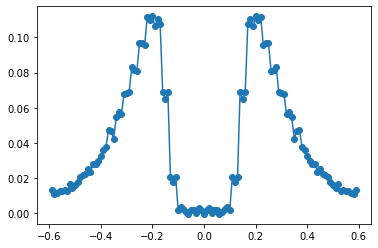

In [270]:
plt.plot(expvals('03',1)[0],expvals('03',1)[1],'-o')

In [259]:
@jit(nopython=True)
def fitting_s5(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

    op1 = optical_func(gammaa)
    n1 = n1_func(gammaa)
    n2 = n2_func(gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

@jit(nopython=True)
def weight_s5(dset, gammaa,g0, alpha,T,N,sym):
    expV, expC, expIR = expvals(dset, sym)
    theoC, theoIR = fitting_s5(gammaa,g0,alpha,T,N,expV)
    weitC = ((theoC - expC)**2)/(np.maximum(0.027,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    weitIR = ((theoIR - expIR)**2)/(np.maximum(1,(theoIR + expIR)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weitC)+np.sum(weitIR)

@jit(nopython=True)
def total_weight_s5(dset,g0,alpha,T,N,sym):
    weightset = [weight_s5(dset, gama,g0, alpha,T,N,sym) for gama in gset]
    weightset = np.array(weightset)
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s5(params,sym):
    g0fac, alpha,T,fac = params
    dset_list = ["01","02","03","04","05", "06", "07", "08", "09", "10"]
    allweightset = np.array([total_weight_s5(dset,10**g0fac,alpha,T/100,10**fac,sym)[1] for dset in dset_list])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s5(dset,g0,alpha,T,N,sym):
    expV, expC, expIR = expvals(dset, sym)
    
    gamma, weit = total_weight_s5(dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    TheoC, TheoIR = fitting_s5(gamma,g0,alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(expV, expC)
    axes[0].plot(expV, TheoC)
    axes[1].plot(expV, expIR)
    axes[1].plot(expV, TheoIR)
    print(np.mean(np.abs(TheoIR)))

0.0075 83.97881458127942
2.164894735057057


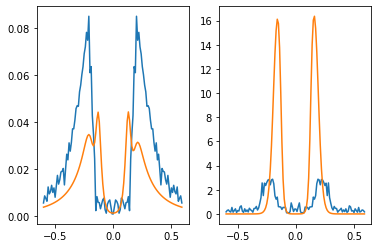

In [260]:
fitplot_s5('02',1e8,0.32,0.06,1e6,1)

In [261]:
result_s5 = minimize(total_set_weight_s5, (8.0, 0.32, 6.0, 6.0),args=(1),method = 'trust-constr')
print(result_s5.success)
if result_s5.success:
    print(result_s5.fun)
    print(result_s5.x)


True
491.4327644820574
[9.76644573 0.41208552 6.77916082 8.01714979]


In [262]:
%%notify
result_s5 = basinhopping(total_set_weight_s5, (8.0, 0.32, 6.0, 6.0),
                      niter=30, minimizer_kwargs={'args':1,"method": 'trust-constr'})#, T=10, stepsize=2)
print(result_s5.lowest_optimization_result.success)
if result_s5.lowest_optimization_result.success:
    print(result_s5.lowest_optimization_result.fun)
    print(result_s5.lowest_optimization_result.x)

# True
# 924.9359577350831
# [ 8.34530295 -0.54847059  8.68743712  7.97144262]

# True
# 415.729077180105
# [8.29184914 0.57569112 8.58983861 8.55455983]

True
435.35630019361884
[ 8.32507261 -0.56800435  8.63864574  8.45504562]


<IPython.core.display.Javascript object>

In [159]:
total_set_weight_s5((8.33396009,   2.88534685,   1.47044094, 11.53911446),1)

142.1817080624646

In [223]:
def fittedplot_s5(res_list,sym,save=False):
    plt.close()
    g0fac,alpha,T,fac = res_list

    dset_list = dset_list2
    allweightset = [total_weight_s5(dset,10**g0fac,alpha,T/100,10**fac,sym)[0] for dset in dset_list]
    
    fig, axes = plt.subplots(9,2,figsize=(10,24))
    axes1 = axes[:,0]
    axes2 = axes[:,1]
    for gamma, dset, axis1, axis2 in zip(allweightset,dset_list,axes1, axes2):
        
        expV, expC, expIR = expvals(dset, sym)
        theoC, theoIR = fitting_s5(gamma,10**g0fac,alpha,T/100,10**fac,expV)
        axis1.plot(expV, expC,label=f'data set = {dset}')
        axis1.plot(expV, theoC,label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylabel('C (fF)')
        
        axis2.plot(expV, expIR,label=f'data set = {dset}')
        axis2.plot(expV, theoIR,label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
        axis2.set_ylabel(r'S ($10^{-8} \Omega^{-1}$)')
        
        
    axes1[-1].set_xlabel(r'$V_{p0}$')
    axes2[-1].set_xlabel(r'$V_{p0}$')
    parameter_string = f"$T = {T*10:.3f} mK $\
            $log_{{10}} \\Gamma^0 = {g0fac:.3f}$\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=12)
    if sym:
        fig.text(
        0.5, 0.902, "Stage 5 (Symmetrized)", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=20)
    fig.text(
        0.5, 0.89, f"Total Weight = {total_set_weight_s5(res_list,sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"Stage5 {[f'{member:.2f}' for member in res_list]} sym.pdf", format='pdf')
        else:
            plt.savefig(f"Stage5 {[f'{member:.2f}' for member in res_list]} Not-sym.pdf", format='pdf')
    

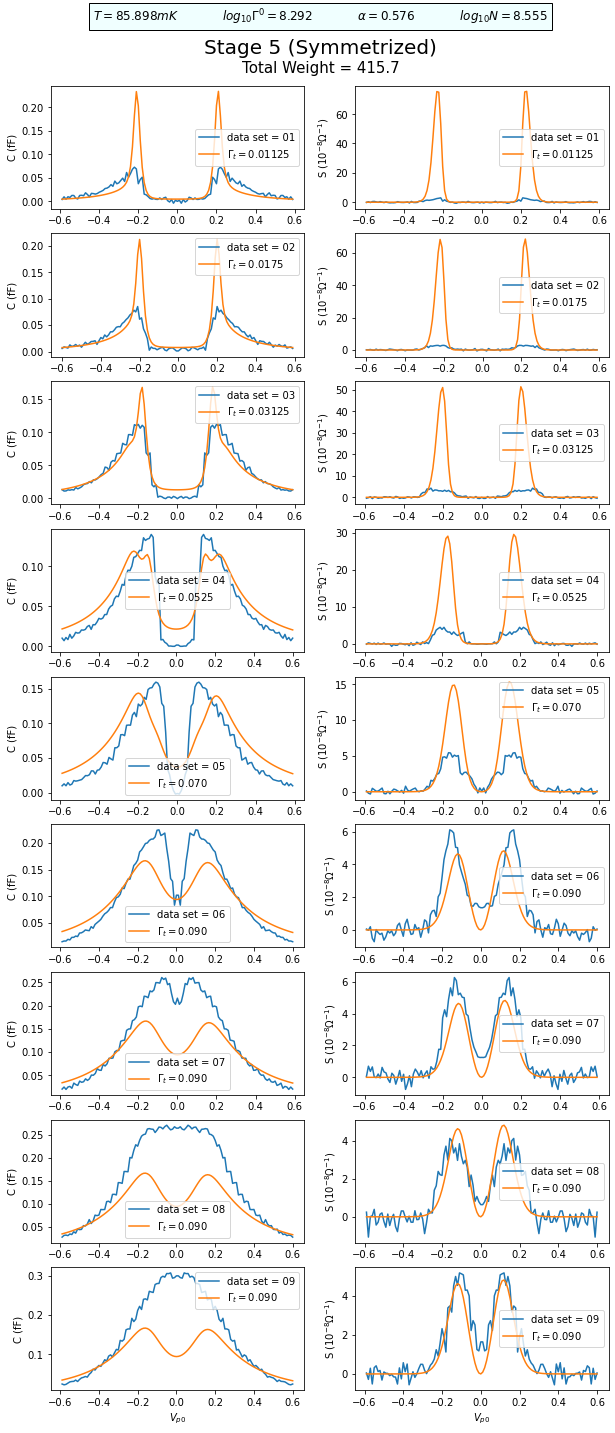

In [233]:
fittedplot_s5(result_s5.x,1,True)
# fittedplot_s5((8.7128097,  0.37301834, 6.68333905, 7.12503457),1)

# fittedplot_s5((8.7128097,  0.37301834, 6.68333905, 7.12503457),1)
# fittedplot_s5((9.34501461,  0.31109881, 6.594998, 6.46504457),1)

In [251]:
def gridplotfit_v2(res_list,sym,save=False):
    plt.close()
    g0fac,alpha,T,fac = res_list
    dset_list = dset_list2
    allweightset = [total_weight_s5(dset,10**g0fac,alpha,T/100,10**fac,sym)[0] for dset in dset_list]
    scale = 4
    fig, (axes1, axes2, axes3, axes4, axes5, axes6) = plt.subplots(6,9,figsize=(9.5*scale,6*scale))

    for gamma, dset,axis1,axis2,axis3,axis4,axis5,axis6 in zip(allweightset,dset_list,axes1,axes2,axes3,axes4,axes5,axes6):
        expV, expC, expIR = expvals(dset, sym)
        theoC, theoIR = fitting_s5(gamma,10**g0fac,alpha,T/100,10**fac,expV)
        
        axis1.plot(expV, expC,label=f'data set = {dset}')
        axis1.plot(expV, theoC,label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
        axis2.plot(expV, expIR,label=f'data set = {dset}')
        axis2.plot(expV, theoIR,label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
#         axis1.set_ylim(0.0,None)
        
        v0 = expV*alpha
        nu = (1 - (v0/0.333))
        op1 = optical_func(gamma)
        s_mg = np.interp(nu, op1[:,0], op1[:,1])
        axis3.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
#         axis2.legend()
        axis3.set_ylim(0.0,2.05)
        
        n1 = n1_func(gamma)
        n2 = n2_func(gamma)
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis4.plot(expV, n_g,label=f'$n_g$')
        axis4.plot(expV, n_e,label=f'$n_e$')
        axis4.legend()
        axis4.set_ylim(0.0,2.1)
        
        C_tot = fitting_s4(gamma,10**g0fac,alpha,T/100,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T/100,10**fac,expV)
        C_q0 = fitting_s2(gamma,alpha,T/100,10**fac,expV)
        
        P0g = p0(s_mg*Delta, T/100, 10**fac)
        axis5.plot(expV,P0g,label=f'$\Gamma_t = ${gamma}')
        axis5.legend()
        
        axis6.plot(expV,C_tot,'k',label=r'$C_{total}$')
        axis6.plot(expV,C_q0,'--',label=r'$C_{q,g}$')
        axis6.plot(expV,C_qn - C_q0,'--',label=r'$C_{q,e}$')
        axis6.plot(expV,C_tot - C_qn,'--',label=r'$C_t$')
        axis6.legend()
        axis6.set_ylim(0.0,None)

    axes1[0].set_ylabel(r'Capacitance, C (fF)',fontsize=15)
    axes2[0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    axes3[0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $',fontsize=15)
    axes4[0].set_ylabel(r'Occupation, $n$',fontsize=15)
    axes5[0].set_ylabel(r'P_{g,0}',fontsize=15)
    axes6[0].set_ylabel('Capacitance, C (fF)',fontsize=15)
    
    axes6[4].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    
                   
    parameter_string = f"$T = {T*10:.3f} mK $\
            $log_{{10}} \\Gamma^0 = {g0fac:.3f}$\
            $\\alpha        = {alpha:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    if sym:
        fig.text(
        0.5, 0.902, f"Stage 5 (Symmetrized) TW = {total_set_weight_s5(res_list,sym):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
#     fig.text(
#         0.5, 0.89, f"Total Weight = {result.fun:.1f}", ha='center', va='center', wrap=False,
#         bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if save:
        if sym:
            plt.savefig(f"2D grid sym {[f'{member[0]}{member[1]:.2f}' for member in zip(['g0','a','T','N'],res_list)]}.pdf", format='pdf')
        else:
            plt.savefig(f"2D grid Not-sym {[f'{member:.2f}' for member in res_list]}.pdf", format='pdf')
      

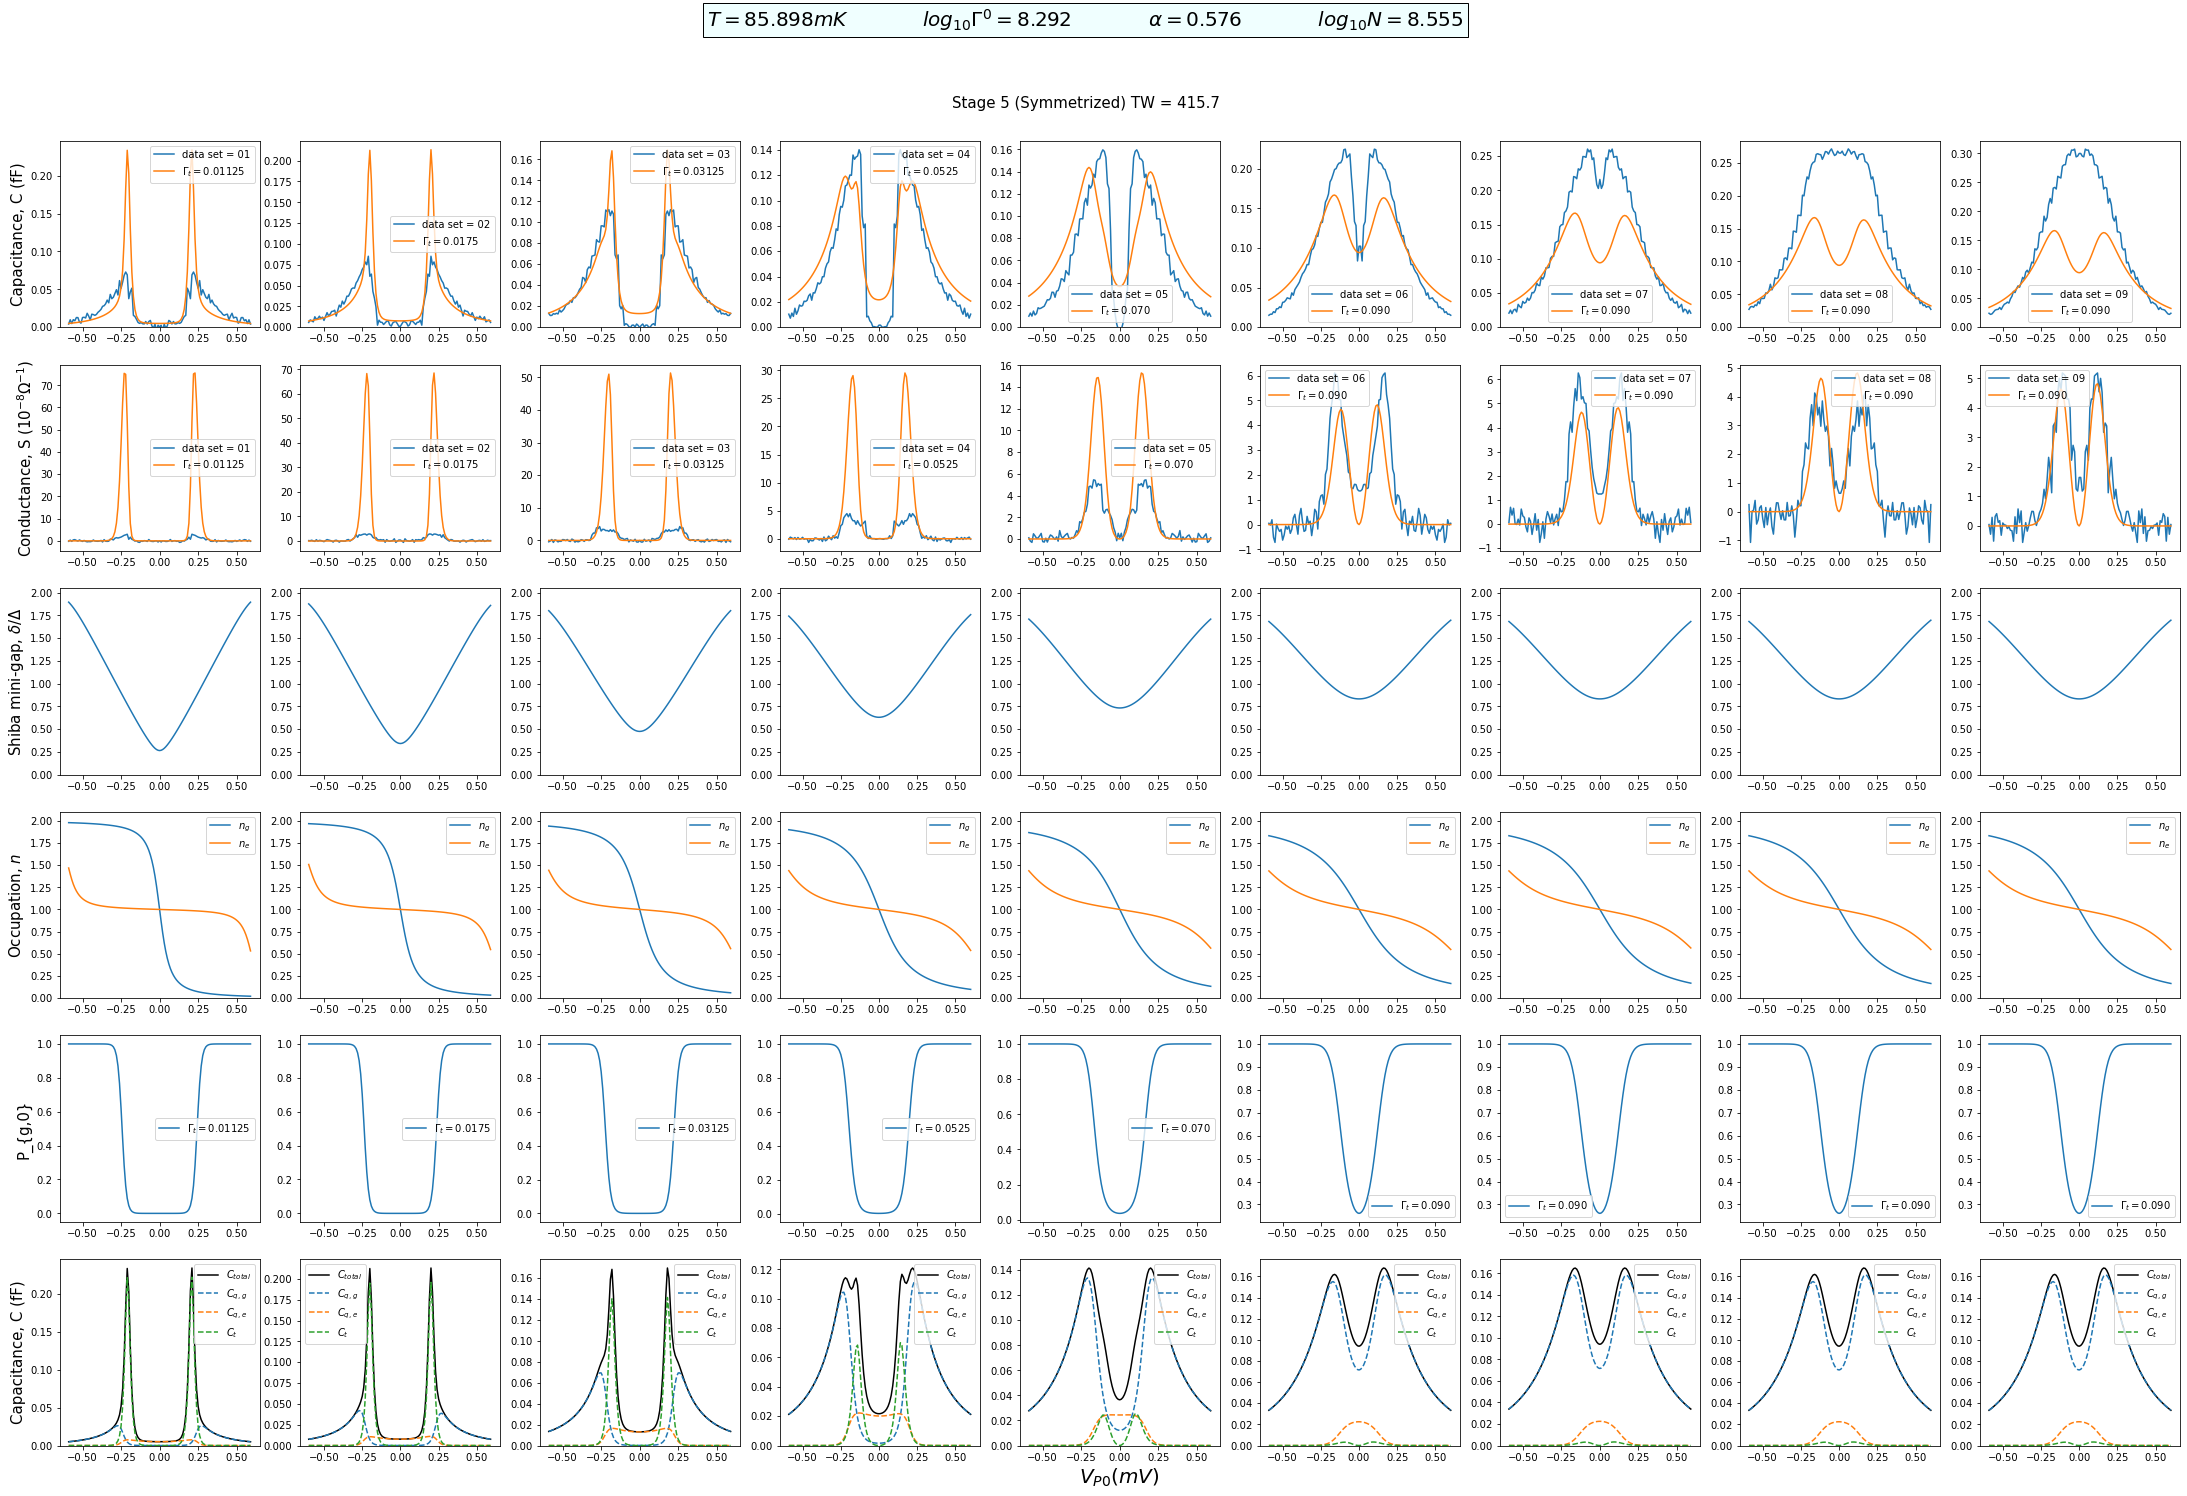

In [252]:
gridplotfit_v2(result_s5.x,1,True)